In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
from birds_utils import DataGenerator, DataGeneratorV2, get_class_audio_files_npy, get_keras_fourier_model
import IPython.display as ipd
import librosa
from tensorflow.keras.applications import ResNet50V2

In [4]:
train_files = np.load('train_files.npy')
val_files = np.load('val_files.npy')
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')

In [5]:
min_std = 0.5
N = 7
duration = 2
dgen_train = DataGeneratorV2(list(train_files)*N, list(train_labels)*N, min_std=min_std, batch_size=32, chunk_seconds=duration)
dgen_val = DataGeneratorV2(list(val_files)*N, list(val_labels)*N, min_std=min_std, batch_size=32, chunk_seconds=duration)

{'aldfly': 0, 'amecro': 1, 'amegfi': 2, 'amepip': 3, 'amered': 4, 'amerob': 5, 'annhum': 6, 'astfly': 7, 'balori': 8, 'banswa': 9}
{'aldfly': 0, 'amecro': 1, 'amegfi': 2, 'amepip': 3, 'amered': 4, 'amerob': 5, 'annhum': 6, 'astfly': 7, 'balori': 8, 'banswa': 9}


In [6]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [7]:
# for layer in resnet50v2.layers:
#     print(layer.name, layer.trainable)

In [8]:
sr = 22050
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2

time_length = int(np.ceil(sr*duration/stride))

In [9]:
for x, c in dgen_val:
    print(c.shape)

(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)


In [10]:
x.shape

(32, 44100, 1)

In [11]:
model_fourier, (inp, cnn_in) = get_keras_fourier_model(window_size, trainable=False)
f_t = model_fourier.predict(x)

In [12]:
idx = 0
f_t[idx].min(), f_t[idx].max(), f_t[idx].shape

(-46.393227, 56.605427, (173, 512))

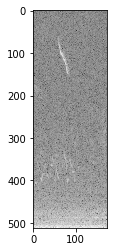

In [13]:
top_db = 10000
processed = np.maximum(f_t[idx], f_t[idx].max() - top_db)
plt.imshow(np.flipud(processed.T), cmap='gray')
plt.show()
ipd.Audio(x[idx].reshape(-1), rate=22050)
# X_t = librosa.stft(x[idx].reshape(-1), n_fft=1024)
# Xdb = np.square(np.abs(X_t))
# Xdb = 10.0 * np.log10(np.maximum(1e-10, Xdb))
# Xdb = librosa.amplitude_to_db(np.abs(X_t))

# plt.imshow(np.flipud(Xdb), cmap='gray')

In [15]:
dgen_val.n_classes

10

In [16]:
# inp = Input(shape=(None,1))
# fourier_out = fourier_model(inp)
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet')
model_fourier, (inp, cnn_in) = get_keras_fourier_model(window_size, trainable=False)

cnn_in = Reshape((time_length, filters, 1))(cnn_in)
cnn_in = Concatenate()([cnn_in, cnn_in, cnn_in])
#cnn_in = BatchNormalization(axis=-1)(cnn_in)
# gap_out = GlobalAveragePooling1D()(fourier_out)
# out = Dense(3, activation='softmax')(gap_out)
resnet_out = resnet50v2(cnn_in)
gap_out = GlobalAveragePooling2D()(resnet_out)
out = Dense(dgen_val.n_classes, activation='softmax')(gap_out)
# model_fourier_out = Model(inp, resnet_out)
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 512)    524800      input_3[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 512)    524800      input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square_2 (TensorFlo [(None, None, 512)]  0           cos[0][0]                        
____________________________________________________________________________________________

In [17]:
model.get_layer('cos').trainable

False

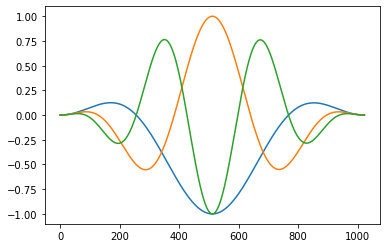

In [18]:
plt.plot(model.get_layer('cos').get_weights()[0][:,0,0])
plt.plot(model.get_layer('cos').get_weights()[0][:,0,1])
plt.plot(model.get_layer('cos').get_weights()[0][:,0,2])

In [19]:
cbs = [
    callbacks.ModelCheckpoint('weights_1024.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-5)
] 


In [20]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(dgen_train, epochs=20, validation_data=dgen_val, callbacks=cbs, use_multiprocessing=False, workers=8)

Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.5177
Epoch 00001: val_accuracy improved from -inf to 0.28526, saving model to weights_1024.hdf5
173/173 [==============================] - 182s 1s/step - loss: 1.4477 - accuracy: 0.5177 - val_loss: 9.2152 - val_accuracy: 0.2853
Epoch 2/20
173/173 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6973
Epoch 00002: val_accuracy did not improve from 0.28526
173/173 [==============================] - 304s 2s/step - loss: 0.9240 - accuracy: 0.6973 - val_loss: 4.7967 - val_accuracy: 0.2796
Epoch 3/20
173/173 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.7699
Epoch 00003: val_accuracy improved from 0.28526 to 0.45032, saving model to weights_1024.hdf5
173/173 [==============================] - 414s 2s/step - loss: 0.6909 - accuracy: 0.7699 - val_loss: 2.1006 - val_accuracy: 0.4503
Epoch 4/20
173/173 [==============================] - ETA: 0s - loss: 0.5411

In [83]:
model.evaluate(dgen_val)

39/39 [==============================] - 70s 2s/step - loss: 2.4317 - accuracy: 0.0617


[2.4316537380218506, 0.06169871613383293]

In [26]:
model.load_weights('weights_1024.hdf5')
model.evaluate(dgen_val)

31/31 [==============================] - 5s 165ms/step - loss: 0.6010 - accuracy: 0.8115


[0.6009795665740967, 0.8114919066429138]

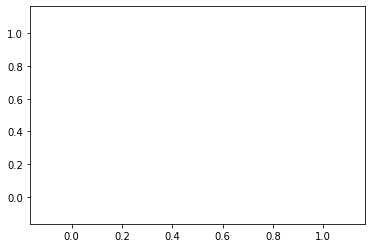

In [84]:
plt.plot(model.get_layer('cos').get_weights()[0][:,0,0])
plt.plot(model.get_layer('cos').get_weights()[0][:,0,1])
plt.plot(model.get_layer('cos').get_weights()[0][:,0,2])

In [25]:
model.get_layer('cos').get_weights()[0][:,0,0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [32]:
from librosa.feature import melspectrogram

In [34]:
for x, y in dgen_val:
    break

In [36]:
x.shape

(128, 110250, 1)

In [39]:
melspectrogram(x[0, 0,0].reshape(-1)).shape

(128, 1)